# Rank analysis
This document investigates the how well bayesian optimisation does in recovering the 'true' number of signatures. This is done by tuning the number of signatures on 100 simulated mutational matrices, generated from 5 random signatures. In total 4 methods are investigated: NMF with scikit-optimize, NMF with optuna, AE with scikit-optimize and AE with optuna. All four methods are defined in the subsequent chunks.
All four methods tune 100 trials to ensure comparable results. The AE methods does, however, have more hyperparameters to tune (lr, optimizer, batch size), meaning that the parameter space to search is larger. Where 100 trials will investigave the full parameter space for NMF, it will not for AE, so the NMF has a higher chance for finding the global minimum.

## Load packages
Firstly, we load the necessary packages for the code to run

In [1]:
import numpy as np
import torch
import pandas as pd
import optuna
import torch.optim as optim
import matplotlib.pyplot as plt
import math

from sklearn import model_selection
from NMFAE_init import NMFAE, train_NMFAE
from functools import partial 
from skopt import space
from skopt import gp_minimize
from functions import simulate_counts
from sklearn.decomposition import NMF
from optuna.trial import TrialState

         Patient1  Patient2  Patient3  Patient4       Patient5  Patient6  \
Type                                                                       
A[C>A]A       0.0       0.0       0.0       0.0  4.377491e-223       0.0   
C[C>A]T       0.0       0.0       0.0       0.0  5.421373e-151       0.0   
C[C>A]G       0.0       0.0       0.0       0.0  1.216781e-308       0.0   
C[C>A]C       0.0       0.0       0.0       0.0  2.620985e-218       0.0   
C[C>A]A       0.0       0.0       0.0       0.0  7.230023e-185       0.0   
...           ...       ...       ...       ...            ...       ...   
A[T>G]G       0.0       0.0       0.0       0.0  3.060737e-278       0.0   
A[T>G]C       0.0       0.0       0.0       0.0  4.081845e-312       0.0   
A[T>G]A       0.0       0.0       0.0       0.0  5.245824e-293       0.0   
G[T>G]T       0.0       0.0       0.0       0.0  8.319947e-278       0.0   
T[T>G]T       0.0       0.0       0.0       0.0  7.020668e-251       0.0   

         Pa

# NMF rank tuning
This section gives two functions for tuning NMF. One using skopt and one using optuna

In [2]:
def MSE_NMF(X, nsig):
    model = NMF(n_components = nsig, init='random', max_iter = 200)
    kf = model_selection.KFold()

    out_err = []
    for train, test in kf.split(X):
        x_train = pd.DataFrame(X).iloc[train,:]
        x_test = pd.DataFrame(X).iloc[test,:]
        exposures = model.fit_transform(x_train)
        signatures = model.components_

        ref_exposures = model.transform(X = x_test)
        rec = np.dot(ref_exposures, signatures)

        MSE = np.mean(((x_test - rec)**2).to_numpy())
        out_err.append(MSE)

    return(np.mean(out_err))

In [12]:
def skopt_NMF(X):
    def objective(params, param_names, X):
        params = dict(zip(param_names, params))
        res = MSE_NMF(X, params['nsig'])
        return res


    param_space = [
        space.Integer(2,15, name = "nsig")
        ]

    param_names = [
        "nsig"
        ]

    #Partial functions allow us to fix a certain number of arguments of a function and generate a new function.
    optimization_NMF = partial(
        objective,
        param_names = param_names,
        X = X
    )


    resNMF = gp_minimize(
        optimization_NMF, 
        dimensions = param_space,
        n_calls = 100,
        n_random_starts = 10,
        verbose = 0,
        n_jobs=3)

    return resNMF.x[0]


In [4]:
def optuna_NMF(X):

    def objective(trial):
        nsig = trial.suggest_int('nsig', 2, 15)
        res = MSE_NMF(X, nsig)
        
        # Handle pruning based on the intermediate value.
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

        return np.mean(res)


    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=100, timeout=600, n_jobs=3)

    trial = study.best_trial

    res = trial.params
    return res['nsig']


# AE rank tuning
This section gives two functions for tuning AE. One using skopt and one using optuna

In [5]:
def MSE_AE(X, nsig, lr, optimizer_name, batch_size):
    model = NMFAE(nsig)
    kf = model_selection.KFold()

    out_err = []
    loss_function = torch.nn.MSELoss(reduction='mean')
    optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr)


    for train, test in kf.split(X):
        x_train = pd.DataFrame(X).iloc[train,:]
        x_test = pd.DataFrame(X).iloc[test,:]

        train_NMFAE(
            epochs = 200, 
            model = model, 
            x_train = x_train, 
            loss_function = loss_function, 
            optimizer = optimizer,
            batch_size = int(batch_size)
            )

        cv_test_tensor = torch.tensor(x_test.values, 
                                        dtype = torch.float32)

        cv_fit = model(cv_test_tensor)
        out_err.append(float(loss_function(cv_fit,cv_test_tensor).detach().numpy()))
    return np.mean(out_err)

In [6]:
def skopt_AE(X):
    def optimize(params, param_names, X):
        params = dict(zip(param_names, params))
        lr = params['lr'] 
        nsig = params['nsig']
        optimizer_name = params['optimizer_name']
        batch_size = params['batch_size']
        res = MSE_AE(X, nsig, lr, optimizer_name, batch_size)
        return res

    param_space = [
        space.Integer(2, 15, name = "nsig"),
        space.Real(0.000001, 1, prior = "uniform", name = "lr"),
        space.Categorical([8, 16, 32, 64], name = 'batch_size'),
        space.Categorical( ["Adam", "RMSprop", "SGD"], name = "optimizer_name")
    ]

    param_names = [
        "nsig", 
        "lr",
        "batch_size",
        "optimizer_name"
    ]

    optimization_AE = partial(
        optimize,
        param_names = param_names,
        X = X
    )

    resAE = gp_minimize(
        optimization_AE, 
        dimensions = param_space,
        n_calls = 100,
        n_random_starts = 10,
        verbose = 0,
        n_jobs=3)
    
    return resAE.x[0]

In [7]:
def optuna_AE(X):

    def objective(trial):
        nsig = trial.suggest_int('nsig', 2, 15)
        lr = trial.suggest_float('lr',1e-5, 1e-1, log=True)
        batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])
        optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD"])
        
        res = MSE_AE(X, nsig, lr, optimizer_name, batch_size)
        

        # Handle pruning based on the intermediate value.
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

        return res

    study = optuna.create_study(direction = "minimize")
    study.optimize(objective, n_trials = 100, timeout = 600, n_jobs=3)

    trial = study.best_trial

    res = trial.params['nsig']
    if math.isnan(res):
        res = 0
    return res

# Rank analysis
This step calculates the ranks found by the two tuning schemes in the two methods.

In [8]:
def rank_analysis(npatients, nsigs):
  X, _,_ = simulate_counts(nsigs, npatients)
  X = X.transpose()
  return(skopt_NMF(X), optuna_NMF(X), optuna_AE(X))
asd = np.array([rank_analysis(4000, 5) for _ in range(50)])
result = pd.DataFrame(asd)
result.columns = ["skopt_NMF", "optuna_NMF", "optuna_AE"]
print(result)

C:\Users\bjyw\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
C:\Users\bjyw\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
C:\Users\bjyw\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
C:\Users\bjyw\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\skl

  skopt_NMF optuna_NMF optuna_AE
0      [13]         15         7
1      [15]         15        14
2      [13]         15         6
3      [14]          5        15
4       [5]          5         6
5       [5]          5        11
6       [5]          5         6
7      [12]          5        15
8       [5]         15        13
9       [5]          5         9


C:\Users\bjyw\AppData\Local\Temp\ipykernel_3216\4163419232.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  asd = np.array([rank_analysis(4000, 5) for _ in range(10)])


TypeError: '<' not supported between instances of 'list' and 'float'

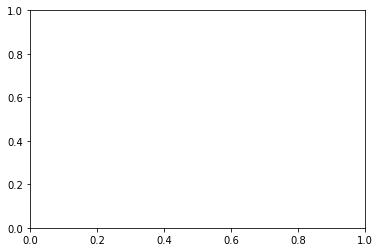

In [9]:
plt.hist(result, label  = result.columns)
plt.title("Number of signatures found in each tuning")
plt.legend()
plt.show()